First of all we are going to install a couple of libraries needed for interacting with Hugging Face. We are going to use HuggingFace for downloading a pretrained model and a dataset we will use for fine-tunning it.

- Lighting: PyTorch Lighting will provide a high-level interface for PyTorch, a popular machine learning framework.
- Datasets: A library for interacting with uploaded datasets available on the Hugging Face Hub.
- Transformers: A library for interacting with pre-trained models available on the Hugging Face Hub.

In [7]:
!pip uninstall pigments

In [8]:
!pip install lightning
!pip install pigments
!pip install transformers==4.23.1
!pip install datasets==2.6.1
!pip install huggingface-hub==0.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pigments: filename=Pigments-1.6-py3-none-any.whl size=650039 sha256=abde90914093c1067d5087204bf2cc945fa3cceecad44023a7cd422c4ef5d674
  Stored in directory: /root/.cache/pip/wheels/36/5f/2a/f4d0060f167bb11e16015ee41b57af8767e89020c7673acc37
Successfully built pigments
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 74.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.21.3
    Uninstalling transformers-4.21.3:
      Successfully uninstalled transformers-4.21.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.9/441.9 kB 42.1 MB/s eta 0:00

In [9]:
!python -V

Python 3.9.16


In [ ]:
# This is necessary only if we want our model to be uploaded into the hugging-face hub
# !huggingface-cli login


In [58]:
import datasets
import lightning as pl
import matplotlib.pyplot as plt
import torch
from lightning import Trainer
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage
from transformers import AutoFeatureExtractor
from transformers import AutoModelForObjectDetection


In [59]:
def fix_channels(t):
    """
    Some images may have 4 channels (transparent images) or just 1 channel (black and white images), in order to let the images have only 3 channels. I am going to remove the fourth channel in transparent images and stack the single channel in back and white images.
    :param t: Tensor-like image
    :return: Tensor-like image with three channels
    """
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

import random
def xyxy_to_xcycwh(box):
    """
    Boxes in images may have the format (x1, y1, x2, y2) and we may need the format (center of x, center of y, width, height).
    :param box: Tensor-like box with format (x1, y1, x2, y2)
    :return: Tensor-like box with format (center of x, center of y, width, height)
    """
    x1, y1, x2, y2 = box.unbind(dim=1)
    width = x2-x1
    height = y2-y1
    xc = x1 + width*0.5
    yc = y1 + height*0.5
    b = [xc, yc, width, height]
    return torch.stack(b, dim=1)

def cxcywh_to_xyxy(x):
    """
    Boxes in images may have the format (center of x, center of y, width, height) and we may need the format (x1, y1, x2, y2).
    :param box: Tensor-like box with format (center of x, center of y, width, height)
    :return: Tensor-like box with format (x1, y1, x2, y2)
    """
    x_c, y_c, w, h = x.unbind(1)
    x1 = x_c - 0.5 * w
    y1 = y_c - 0.5 * h
    x2 = x_c + 0.5 * w
    y2 = y_c + 0.5 * h
    b = [x1, y1, x2, y2]
    return torch.stack(b, dim=1)

In [60]:
COLORS = ['lightcoral', 'yellowgreen', 'darkturquoise', 'hotpink', 'mediumslateblue']

def rescale_bboxes(out_bbox, size, down=True):
    """
    Boxes information contains values between 0 and 1 instead of values in pixels. This is made in order to make the boxes independant from the size of the image. But we may need to re-escale the box.
    """
    img_w, img_h = size
    if down:
        b = torch.Tensor(out_bbox) / torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    if not down:
        b = torch.Tensor(out_bbox) * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, boxes, class_labels):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for (xmin, ymin, xmax, ymax), c, label in zip(boxes, colors, class_labels):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        ax.text(xmin, ymin, str(label), fontsize=15,
                bbox=dict(facecolor=c, alpha=0.5))
    plt.axis('off')
    plt.show()

## Downloading and visualizing the fashionpedia dataset

In [61]:
# 95% Percent of the dataset will be used for training
train_dataset = datasets.load_dataset("meher92/neckline_sleeve_imgs_600", use_auth_token=True, split=datasets.ReadInstruction("train",from_=0, to=95, unit="%"))
# 5% of the dataset will be used for validation
val_dataset = datasets.load_dataset("meher92/neckline_sleeve_imgs_600", use_auth_token=True, split=datasets.ReadInstruction("train",from_=95, to=100, unit="%"))

Using custom data configuration meher92--neckline_sleeve_imgs_600-718a5c20b6d69738


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/meher92___parquet/meher92--neckline_sleeve_imgs_600-718a5c20b6d69738/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Using custom data configuration meher92--neckline_sleeve_imgs_600-718a5c20b6d69738
Found cached dataset parquet (/root/.cache/huggingface/datasets/meher92___parquet/meher92--neckline_sleeve_imgs_600-718a5c20b6d69738/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [62]:
# cats = train_dataset['objects']['category']
cats = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

def idx_to_text(indexes):
    """
    Converts an index into a category label.
    :param indexes: List of indexes
    :return: List of category labels
    """
    labels = []
    for i in indexes:
        labels.append(cats[i])
    return labels

In [63]:
train_dataset

Dataset({
    features: ['image', 'width', 'height', 'objects'],
    num_rows: 613
})

In [64]:
val_dataset

Dataset({
    features: ['image', 'width', 'height', 'objects'],
    num_rows: 32
})

Plotting random item 165


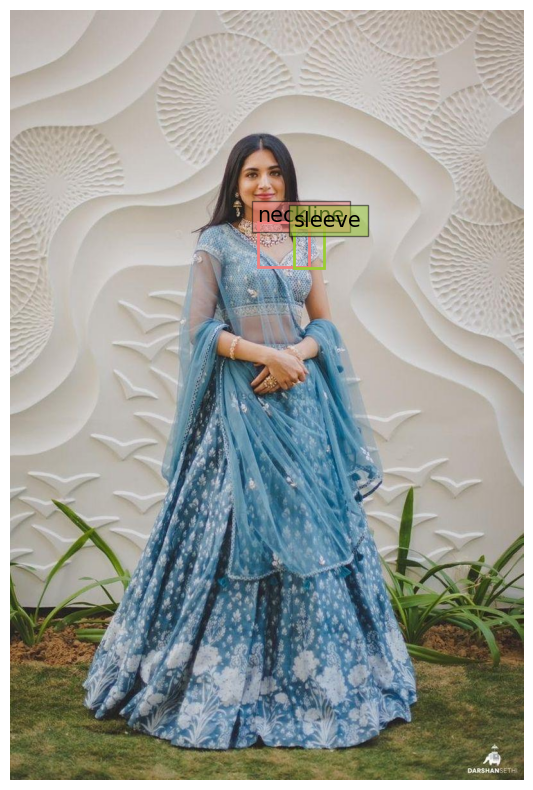

In [65]:
random_i = random.randint(0, train_dataset.num_rows)
print(f"Plotting random item {random_i}")
random_item = train_dataset[random_i]
plot_results(random_item['image'], random_item['objects']['bbox'], idx_to_text(random_item['objects']['category']))

### Preprocessing our dataset

In [66]:
# In order to use our images for the training, we're going to preprocess them, it is possible to use the YOLOs preprocessor.
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=816, max_size=864)

In [67]:
def transform(batch):
    inputs = {}
    image = batch['image']
    image = fix_channels(ToTensor()(image[0]))
    inputs['pixel_values'] = feature_extractor([image], return_tensors='pt')['pixel_values']
    labels = []
    bbox = [rescale_bboxes(batch['objects'][i]['bbox'], (batch['width'][i], batch['height'][i])) for i in range(len(batch['objects']))]
    bbox = [xyxy_to_xcycwh(torch.Tensor(bbox_i)) for bbox_i in bbox]
    labels.append({
        "boxes": bbox,
        "class_labels": [object['category'] for object in batch['objects']],
        # "image_id": torch.Tensor([batch['image_id']]).int(),
        "area": [object['area'] for object in batch['objects']],
        "iscrowd": torch.Tensor([0 for _ in batch['objects']]).int(),
        "orig_size": torch.Tensor([(batch['width'], batch['height'])]).int(),
        "size": torch.Tensor([inputs['pixel_values'].shape[1:]])[0].int(),
    })
    inputs['labels'] = labels
    return inputs

In [68]:
prepared_train = train_dataset.with_transform(transform)
prepared_val = val_dataset.with_transform(transform)

In [69]:
def collate_fn(batch):
    collated = {}
    collated["pixel_values"] = feature_extractor.pad([item['pixel_values'] for item in batch], return_tensors="pt")['pixel_values']
    collated["labels"] = []
    for item in batch:
        item['labels']['boxes'] = torch.stack(item['labels']['boxes'])[0]
        item['labels']['area'] = torch.Tensor(item['labels']['area'])
        item['labels']['class_labels'] = torch.Tensor(item['labels']['class_labels'])[0]
        item['labels']['class_labels'] = item['labels']['class_labels'].type(torch.LongTensor)
        collated["labels"].append(item['labels'])
    return collated

In [70]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 613
Number of validation examples: 32


In [71]:
BATCH_SIZE = 1
train_dataloader = DataLoader(prepared_train, collate_fn=collate_fn, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(prepared_val, collate_fn=collate_fn, batch_size=BATCH_SIZE)

In [78]:
item = next(iter(train_dataloader))

In [84]:
# item

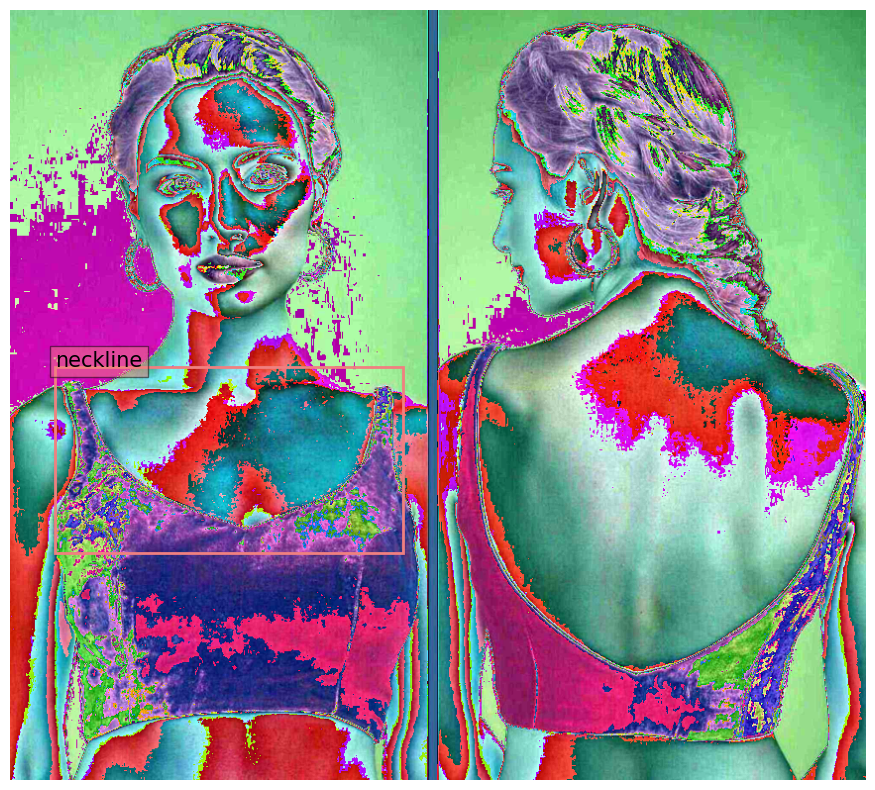

In [80]:
random_i = random.randint(0, BATCH_SIZE-1)
random_i = 0
pil_image = transforms.ToPILImage()(item['pixel_values'][random_i])
class_labels = item['labels'][random_i]['class_labels']
size = pil_image.size
boxes = rescale_bboxes(cxcywh_to_xyxy(item['labels'][random_i]['boxes']), size, down=False)
plot_results(pil_image, boxes, idx_to_text(class_labels.tolist()))

In [81]:
class Detr(pl.LightningModule):
    def __init__(self, lr, weight_decay):
        super().__init__()
        self.model = AutoModelForObjectDetection.from_pretrained(
            "valentinafeve/yolos-fashionpedia",
            num_labels=len(cats),
            ignore_mismatched_sizes=True)
        self.lr = lr
        self.weight_decay = weight_decay
    
    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)
        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]
        outputs = self.model(pixel_values=pixel_values, labels=labels)
        
        loss = outputs.loss
        loss_dict = outputs.loss_dict
        return loss, loss_dict
    
    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # self.log("training_loss", loss)
        self.log("training_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # self.log("validation_loss", loss)
        self.log("validation_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)
        return optimizer

    def train_dataloader(self):
        return train_dataloader
    
    def val_dataloader(self):
        return val_dataloader

Here we define the model, and verify the outputs.

In [82]:
model = Detr(lr=2.5e-5, weight_decay=1e-4)

In [92]:
from lightning.pytorch.callbacks import ModelCheckpoint

# Init ModelCheckpoint callback, monitoring 'val_loss'
checkpoint_callback = ModelCheckpoint(monitor="validation_loss")


In [ ]:
trainer = Trainer(max_epochs=3, accelerator="gpu", devices=1)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
--------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.670   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [56]:
# model

In [85]:
model.model.push_to_hub("meher92/yolos-fashionpedia-sntuned")

CommitInfo(commit_url='https://huggingface.co/meher92/yolos-fashionpedia-sntuned/commit/d45d8e1ec0b74015701ee74d9deac749a8fcde55', commit_message='Upload YolosForObjectDetection', commit_description='', oid='d45d8e1ec0b74015701ee74d9deac749a8fcde55', pr_url=None, pr_revision=None, pr_num=None)

In [91]:
# lmodel = Detr.load_from_checkpoint("/notebooks/lightning_logs/version_1/checkpoints/epoch=4-step=3000.ckpt", lr=2.5e-5, weight_decay=1e-4)

That's it!